In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#M2 Mac의 그래픽카드 가속 옵션
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')
print(device)
#X,Y 데이터 로딩
X = pd.read_csv('/content/drive/MyDrive/Data_X.csv').values
y = pd.read_csv('/content/drive/MyDrive/Data_Y.csv').values

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)







cuda


In [3]:
#Variable로 감싸진 텐서? .backward() 가 호출될 때 자동으로 계산된다.
X_tensors = Variable(torch.Tensor(X_ss))
y_tensors = Variable(torch.Tensor(y))


print('X_tensors shape:', X_tensors.shape)
print('y_tensors shape:', y_tensors.shape)

X_tensors shape: torch.Size([168, 7])
y_tensors shape: torch.Size([168, 1])


## device 옮기기

In [4]:
X_tensors = X_tensors.to(device=device, dtype=torch.float32)
y_tensors = y_tensors.to(device=device, dtype=torch.float32)


In [5]:
# 데이터 정보와 차원 지정
train_size = 160

input_dim = len(X_tensors[1])          #입력 변수 수
d_model = train_size
output_dim = len(y_tensors[1])         #출력 변수 수
num_epochs = 1000        #에폭
num_layers = 6          #인코더, 디코더 중첩 수
num_heads = 2           #데이터를 병렬적으로 처리하는 attention의 헤드 수
dim_feedforward = 1024  #피드포워드 신경망의 차원
dropout = 0             #dropout
learning_rate = 0.00001

# 데이터로더 객체 생성
batch_size = train_size
train_data = TensorDataset(X_tensors[:train_size, :], y_tensors[:train_size,  :])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_data = TensorDataset(X_tensors[train_size:,  :], y_tensors[train_size:, :])
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [6]:
# 트랜스포머 모델 정의
class TransformerModel(nn.Module): #nn.Module을 상속받아 트랜스포머 모델 클래스 생성
    def __init__(self, input_dim, d_model, output_dim, num_heads, num_layers): # 생성자 정의
        super(TransformerModel, self).__init__() #부모 클래스의 생성자 호출
        self.embedding = nn.Linear(input_dim, d_model) #임베딩 레이어: 입력 차원에서 모델 차원으로 선형 변환
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers


        self.transformer = nn.Transformer(d_model, num_heads, num_layers, num_layers, dim_feedforward, dropout) # 트랜스포머 레이어 생성
        self.fc = nn.Linear(d_model, output_dim) #출력 레이어: 모델 차원에서 출력 차원으로 선형 변환

    def forward(self, x): # forward 전파 메서드 정의
        x = x.permute(1, 0)      #배치 차원과 시퀀스 차원을 바꾸어 트랜스포머 입력에 맞게 조정
        x = self.embedding(x)       #임베딩 레이어 통과
        x = self.transformer(x, x)  #트랜스포머 레이어 통과 (셀프 어텐션)
        x = self.fc(x[-1])          #마지막 시퀀스만 가져와 출력 레이어 통과
        return x                    #결과 반환


#모델, 손실함수와 옵티마이저 정의
model = TransformerModel(input_dim, d_model, output_dim, num_heads, num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Transformer 모델 정의

In [7]:
# 트랜스포머 모델 정의
class TransformerModel(nn.Module): #nn.Module을 상속받아 트랜스포머 모델 클래스 생성
    def __init__(self, input_dim, d_model, output_dim, num_heads, num_layers): # 생성자 정의
        super(TransformerModel, self).__init__() #부모 클래스의 생성자 호출
        self.embedding = nn.Linear(input_dim, d_model) #임베딩 레이어: 입력 차원에서 모델 차원으로 선형 변환
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers


        self.transformer = nn.Transformer(d_model, num_heads, num_layers, num_layers, dim_feedforward, dropout) # 트랜스포머 레이어 생성
        self.fc = nn.Linear(d_model, output_dim) #출력 레이어: 모델 차원에서 출력 차원으로 선형 변환

    def forward(self, x): # forward 전파 메서드 정의

        x = self.embedding(x)       #임베딩 레이어 통과
        x = self.transformer(x, x)  #트랜스포머 레이어 통과 (셀프 어텐션)
        x = self.fc(x[-1])          #마지막 시퀀스만 가져와 출력 레이어 통과
        return x                    #결과 반환


#모델, 손실함수와 옵티마이저 정의
model = TransformerModel(input_dim, d_model, output_dim, num_heads, num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
# 빈 predict 항목 생성
predict = torch.empty(len(X_tensors), 1, requires_grad=False)  # requires_grad를 False로 설정하여 중복 역전파 방지
predict[:train_size] = y_tensors[:train_size]
predict

tensor([[1.0019],
        [0.9965],
        [0.9911],
        [0.9911],
        [0.9857],
        [0.9911],
        [0.9911],
        [0.9857],
        [0.9803],
        [0.9803],
        [0.9803],
        [0.9750],
        [0.9750],
        [0.9750],
        [0.9696],
        [0.9696],
        [0.9696],
        [0.9696],
        [0.9696],
        [0.9965],
        [0.9965],
        [0.9911],
        [0.9857],
        [0.9857],
        [0.9857],
        [0.9750],
        [0.9750],
        [0.9750],
        [0.9696],
        [0.9696],
        [0.9965],
        [0.9857],
        [0.9803],
        [0.9750],
        [0.9696],
        [0.9696],
        [0.9642],
        [0.9588],
        [0.9534],
        [0.9534],
        [0.9534],
        [0.9480],
        [0.9534],
        [0.9480],
        [0.9426],
        [0.9372],
        [0.9372],
        [0.9642],
        [0.9588],
        [0.9534],
        [0.9480],
        [0.9426],
        [0.9372],
        [0.9372],
        [0.9319],
        [0

## Window 분할

In [9]:
# train_size 다음 스텝부터 예측 시작
for i in range(train_size - 1, len(X_tensors)-1):
    # 앞서 정해준 epoch 수만큼 모델 학습
    for epoch in range(num_epochs):
        outputs = model.forward(X_tensors[i - (train_size-1):i, :])
        optimizer.zero_grad()

        loss = criterion(outputs, y_tensors[i])
        loss.backward(retain_graph=True)  # 역전파 기울기 학습
        optimizer.step()  # 오차 업데이트
        if (epoch + 1) % num_epochs == 0:
            print("step: %d, epoch: %d, loss: %1.7f" % (i + 1, epoch + 1, loss.item()))

        with torch.no_grad():
            predict[i+1] = model(X_tensors[i+1].unsqueeze(0))



        #### 여기 위주로 수정하면 됨!!
        predicted = predict.cpu().data.numpy()      #학습시킨 데이터를 numpy() 배열화 + mps의 텐서를 cpu로 복사

        predicted= ms.inverse_transform(predicted)  #numpy 배열화된 X를 MinMax 스케일링 후, inverse transform 진행
        # 예측된 다음 step을 다시 학습 재료로 넣어줘야함!
        y_tensors[i+1] = torch.tensor(predicted[i+1])

step: 160, epoch: 1000, loss: 0.0000000
step: 161, epoch: 1000, loss: 0.0000000
step: 162, epoch: 1000, loss: 0.0000000
step: 163, epoch: 1000, loss: 0.0000000
step: 164, epoch: 1000, loss: 0.0000000
step: 165, epoch: 1000, loss: 0.0000000
step: 166, epoch: 1000, loss: 0.0000000
step: 167, epoch: 1000, loss: 0.0000000


## 학습

In [10]:
y_tensors=y_tensors.data.cpu().numpy()

## 예측 시작

In [11]:
#x,y 데이터 정규화
df_y_ms = y
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_y_ms = df_y_ms.to(device=device, dtype=torch.float32)
label_y = df_y_ms.data.cpu().numpy()              #y데이터도 numpy() 배열화 + mps의 텐서를 cpu로 복사


In [12]:
y_tensors



array([[1.0018853 ],
       [0.99649876],
       [0.9911123 ],
       [0.9911123 ],
       [0.9857258 ],
       [0.9911123 ],
       [0.9911123 ],
       [0.9857258 ],
       [0.98033935],
       [0.98033935],
       [0.98033935],
       [0.9749529 ],
       [0.9749529 ],
       [0.9749529 ],
       [0.9695664 ],
       [0.9695664 ],
       [0.9695664 ],
       [0.9695664 ],
       [0.9695664 ],
       [0.99649876],
       [0.99649876],
       [0.9911123 ],
       [0.9857258 ],
       [0.9857258 ],
       [0.9857258 ],
       [0.9749529 ],
       [0.9749529 ],
       [0.9749529 ],
       [0.9695664 ],
       [0.9695664 ],
       [0.99649876],
       [0.9857258 ],
       [0.98033935],
       [0.9749529 ],
       [0.9695664 ],
       [0.9695664 ],
       [0.96417993],
       [0.9587934 ],
       [0.95340693],
       [0.95340693],
       [0.95340693],
       [0.94802046],
       [0.95340693],
       [0.94802046],
       [0.942634  ],
       [0.9372475 ],
       [0.9372475 ],
       [0.964

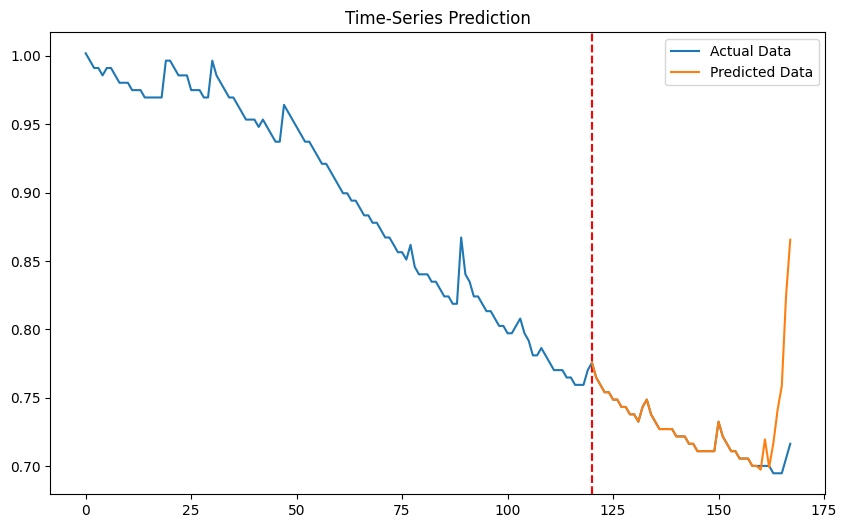

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.axvline(x=120, c='r', linestyle='--')       #120번째 항목부터 구획하기

plt.plot(label_y, label='Actual Data')
plt.plot(range(120,168),y_tensors[120:168], label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()